In [1]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

import pandas as pd
import numpy as np

from PIL import Image

from skimage.feature import hog
from skimage.color import rgb2grey

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc

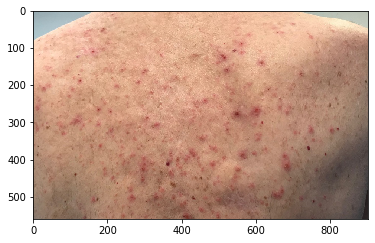

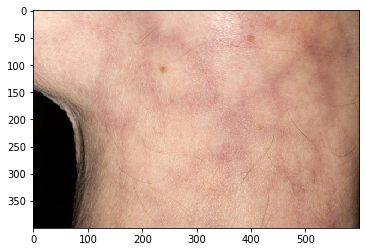

In [2]:
labels = pd.read_csv("dt/labels.csv", index_col=0)

labels.head()

def get_image(row_id, root="dt/"):
    """
    Converts an image number into the file path where the image is located, 
    opens the image, and returns the image as a numpy array.
    """
    filename = "{}.jpg".format(row_id)
    file_path = os.path.join(root, filename)
    img = Image.open(file_path)
    return np.array(img)

# subset the dataframe to just Apis (genus is 0.0) get the value of the sixth item in the index
apis_row = labels[labels.genus == 0.0].index[5]

# show the corresponding image of an Apis
plt.imshow(get_image(apis_row))
plt.show()

# subset the dataframe to just Bombus (genus is 1.0) get the value of the sixth item in the index
bombus_row = labels[labels.genus == 1.0].index[6]

plt.imshow(get_image(bombus_row))
plt.show()

Color bombus image has shape:  [[[255 220 200]
  [253 218 198]
  [250 215 195]
  ...
  [133 101  78]
  [135 103  80]
  [139 108  87]]

 [[250 218 197]
  [250 218 197]
  [250 218 197]
  ...
  [135 103  80]
  [138 106  83]
  [143 112  91]]

 [[250 218 197]
  [251 219 198]
  [253 221 200]
  ...
  [134 102  79]
  [138 106  83]
  [144 113  92]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 45  31  22]
  [ 43  29  20]
  [ 40  27  19]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 47  33  24]
  [ 41  27  18]
  [ 37  24  16]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [ 53  39  30]
  [ 44  30  21]
  [ 38  25  17]]]
Greyscale bombus image has shape:  [[0.88625686 0.87841373 0.86664902 ... 0.41624196 0.4240851  0.4434251 ]
 [0.87563098 0.87563098 0.87563098 ... 0.4240851  0.4358498  0.45911137]
 [0.87563098 0.87955255 0.88739569 ... 0.42016353 0.4358498  0.46303294]
 ...
 [0.         0.         0.         ... 0.13069059 0.12284745 0.11445373]
 [0.   

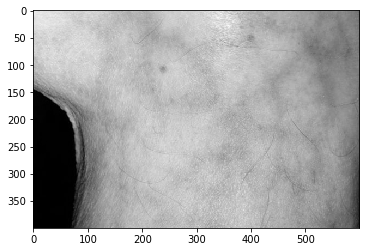

In [3]:
# load a bombus image using our get_image function and bombus_row from the previous cell
bombus = get_image(bombus_row)

print('Color bombus image has shape: ', bombus)

# convert the bombus image to greyscale
grey_bombus = rgb2grey(bombus)

plt.imshow(grey_bombus, cmap=mpl.cm.gray)

print('Greyscale bombus image has shape: ', grey_bombus)

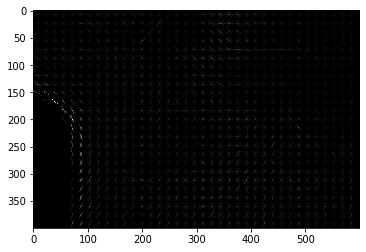

In [4]:
# run HOG using our greyscale bombus image
hog_features, hog_image = hog(grey_bombus,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(16, 16))

plt.imshow(hog_image, cmap=mpl.cm.gray)

In [5]:
def create_features(img):
    # flatten three channel color image
    color_features = img.flatten()
    # convert image to greyscale
    grey_image = rgb2grey(img)
    # get HOG features from greyscale image
    hog_features = hog(grey_image, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    # combine color and hog features into a single array
    flat_features = np.hstack(color_features)
    return flat_features

bombus_features = create_features(bombus)

print(bombus_features)

[255 220 200 ...  38  25  17]


In [ ]:
def create_feature_matrix(label_dataframe):
    features_list = []
    
    for img_id in label_dataframe.index:
        # load image
        img = get_image(img_id)
        # get features for image
        image_features = create_features(img)
        features_list.append(image_features)
        
    # convert list of arrays into a matrix
    feature_matrix = np.array(features_list)
    return feature_matrix

# run create_feature_matrix on our dataframe of images
feature_matrix = create_feature_matrix(labels)

In [229]:
print('Feature matrix shape is: ', feature_matrix.shape)

Feature matrix shape is:  (106,)


In [336]:
d=feature_matrix
d

array([array([250, 255, 251, ..., 253, 253, 253], dtype=uint8),
       array([229, 208, 207, ...,  41,  39,  40], dtype=uint8),
       array([225, 168, 139, ..., 101, 115, 128], dtype=uint8),
       array([142,  97,  66, ...,  86,  67,  53], dtype=uint8),
       array([255, 255, 255, ...,  43,  70, 123], dtype=uint8),
       array([  0,   0,   0, ..., 144, 135, 120], dtype=uint8),
       array([251, 252, 246, ..., 254, 255, 253], dtype=uint8),
       array([119, 116, 109, ..., 161, 158, 151], dtype=uint8),
       array([115, 119,  96, ..., 149, 143, 111], dtype=uint8),
       array([207, 206, 212, ...,  25,  26,  21], dtype=uint8),
       array([231, 199, 176, ..., 162, 115,  89], dtype=uint8),
       array([  0,   5,   1, ..., 147, 114,  79], dtype=uint8),
       array([204, 131, 124, ...,  87,  86,  65], dtype=uint8),
       array([206, 123, 131, ...,  89,  83,  49], dtype=uint8),
       array([ 44,  39,  43, ...,  62,  91, 161], dtype=uint8),
       array([138, 102,  78, ...,  18,  

feature_matrix.shape

In [337]:
d = d.tolist()

In [338]:
d

[array([250, 255, 251, ..., 253, 253, 253], dtype=uint8),
 array([229, 208, 207, ...,  41,  39,  40], dtype=uint8),
 array([225, 168, 139, ..., 101, 115, 128], dtype=uint8),
 array([142,  97,  66, ...,  86,  67,  53], dtype=uint8),
 array([255, 255, 255, ...,  43,  70, 123], dtype=uint8),
 array([  0,   0,   0, ..., 144, 135, 120], dtype=uint8),
 array([251, 252, 246, ..., 254, 255, 253], dtype=uint8),
 array([119, 116, 109, ..., 161, 158, 151], dtype=uint8),
 array([115, 119,  96, ..., 149, 143, 111], dtype=uint8),
 array([207, 206, 212, ...,  25,  26,  21], dtype=uint8),
 array([231, 199, 176, ..., 162, 115,  89], dtype=uint8),
 array([  0,   5,   1, ..., 147, 114,  79], dtype=uint8),
 array([204, 131, 124, ...,  87,  86,  65], dtype=uint8),
 array([206, 123, 131, ...,  89,  83,  49], dtype=uint8),
 array([ 44,  39,  43, ...,  62,  91, 161], dtype=uint8),
 array([138, 102,  78, ...,  18,  16,  17], dtype=uint8),
 array([146,  87,  71, ...,   9,  16,  24], dtype=uint8),
 array([255, 2

min_len=37000000
for a in d:
    min_len = len(a) if len(a) < min_len else min_len
print(min_len)

for i in range(len(d)):
    if len(d[i])<36578304:
        for j in range(36578304-len(d[i])):
            np.append(d[i],0)
d

for i in range(len(d)):
    if len(d[i])>min_len:
        d[i]=d[i][:min_len]
d

In [339]:
for i in range(len(d)):
    if len(d[i])>30000:
        d[i]=d[i][:30000]
d

[array([250, 255, 251, ..., 230, 255, 255], dtype=uint8),
 array([229, 208, 207, ..., 172, 151, 146], dtype=uint8),
 array([225, 168, 139, ..., 225, 136, 122], dtype=uint8),
 array([142,  97,  66, ..., 153, 103,  70], dtype=uint8),
 array([255, 255, 255, ..., 255, 255, 255], dtype=uint8),
 array([  0,   0,   0, ..., 215, 212, 203], dtype=uint8),
 array([251, 252, 246, ..., 170, 171, 139], dtype=uint8),
 array([119, 116, 109, ..., 104, 107, 100], dtype=uint8),
 array([115, 119,  96, ..., 106, 110,  85], dtype=uint8),
 array([207, 206, 212, ..., 201, 199, 187], dtype=uint8),
 array([231, 199, 176, ..., 228, 206, 183], dtype=uint8),
 array([0, 5, 1, ..., 0, 8, 9], dtype=uint8),
 array([204, 131, 124, ..., 158,  87,  83], dtype=uint8),
 array([206, 123, 131, ..., 144,  72,  75], dtype=uint8),
 array([ 44,  39,  43, ..., 105,  72,  65], dtype=uint8),
 array([138, 102,  78, ..., 143, 102,  82], dtype=uint8),
 array([146,  87,  71, ..., 178, 144, 135], dtype=uint8),
 array([255, 255, 255, ...

In [340]:
d=np.array(d)

In [341]:
d

array([[250, 255, 251, ..., 230, 255, 255],
       [229, 208, 207, ..., 172, 151, 146],
       [225, 168, 139, ..., 225, 136, 122],
       ...,
       [255, 255, 255, ..., 224, 178, 162],
       [254, 255, 255, ..., 162, 103,  69],
       [ 12,   8,   7, ..., 155, 106, 109]], dtype=uint8)

In [342]:
d.shape

(106, 30000)

In [343]:
ss = StandardScaler()
# run this on our feature matrix
skin_stand = ss.fit_transform(d)

pca = PCA(n_components=500)
# use fit_transform to run PCA on our standardized matrix
skin_pca = ss.fit_transform(skin_stand)
# look at new shape
print('PCA matrix shape is: ', skin_pca.shape)

PCA matrix shape is:  (106, 30000)


In [344]:
X = pd.DataFrame(skin_pca)
y = pd.Series(labels.genus.values)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.3,
                                                    random_state=1234123)

# look at the distrubution of labels in the train set
pd.Series(y_train).value_counts()

0    26
1    25
2    23
dtype: int64

In [345]:
svm = SVC(kernel='rbf', probability=True, random_state=42)

# fit model
svm.fit(X_train, y_train)

SVC(probability=True, random_state=42)

In [346]:
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

SVC(gamma='auto', kernel='linear', probability=True, random_state=42)

In [347]:
y_pred = svm.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.34375


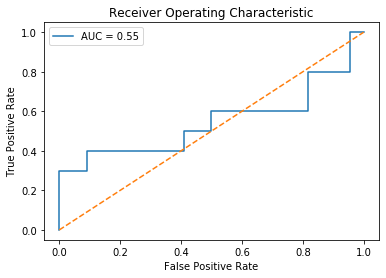

In [348]:
probabilities = svm.predict_proba(X_test)

# select the probabilities for label 1.0
y_proba = probabilities[:, 1]

# calculate false positive rate and true positive rate at different thresholds
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba, pos_label=1)

# calculate AUC
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
# plot the false positive rate on the x axis and the true positive rate on the y axis
roc_plot = plt.plot(false_positive_rate,
                    true_positive_rate,
                    label='AUC = {:0.2f}'.format(roc_auc))

plt.legend(loc=0)
plt.plot([0,1], [0,1], ls='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');